## Lab5

### zad1

In [13]:
using DataFrames, CSV, Statistics, Plots, Plots.PlotMeasures, Random

function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

Asmall = [[1.0 4.0]; [0.0 1.0]]
Bsmall = Asmall

naive_multiplication(Asmall, Bsmall)
better_multiplication(Asmall, Bsmall)
@elapsed Asmall * Bsmall

results = DataFrame(Size = Int[], naive_multiplication = Float64[], better_multiplication = Float64[], BLAS = Float64[]) 

for i in 50:50:500
    for _ in 1:10
        A = rand(0:9,(i,i))
        B = rand(0:9,(i,i))

        naive = @elapsed naive_multiplication(A, B)
        better = @elapsed better_multiplication(A, B)
        blas = @elapsed A*B

        push!(results, (i, naive, better, blas))
    end
end

In [14]:
results = CSV.read("results.csv", DataFrame)

Row,Size,naive_multiplication,better_multiplication,BLAS
,Int64,Float64,Float64,Float64
1,50,0.0003115,0.0005563,5.46e-5
2,50,0.0001,0.0001108,5.46e-5
3,50,8.64e-5,0.000111,4.85e-5
4,50,8.57e-5,0.0001107,4.7e-5
5,50,0.0001187,0.0001435,8.54e-5
6,50,0.0001298,0.000182,8.93e-5
7,50,0.0001246,0.0002762,0.0001151
8,50,0.0001406,0.0001211,6.7e-5
9,50,9.16e-5,0.0001146,5.14e-5


In [15]:
res = combine(groupby(results, :Size),
    :naive_multiplication => mean => :naive_mean,:naive_multiplication => std => :naive_std,
    :better_multiplication => mean => :better_mean, :better_multiplication => std => :better_std,
    :BLAS => mean => :blas_mean, :BLAS => std => :blas_std)

Row,Size,naive_mean,naive_std,better_mean,better_std,blas_mean,blas_std
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,50,0.00012829,6.72609e-5,0.00018457,0.000140532,6.684e-5,2.25452e-5
2,100,0.00083211,3.88038e-5,0.00084858,1.89864e-5,0.00042308,0.000268799
3,150,0.00540124,0.00811862,0.00295065,0.000227835,0.00113425,6.75332e-5
4,200,0.00708636,0.000466203,0.00684365,0.000439103,0.00295118,0.000315785
5,250,0.0137934,0.000414746,0.0139819,0.00108368,0.00485606,0.000264308
6,300,0.0251149,0.00219368,0.0238227,0.00154188,0.00939855,0.00081398
7,350,0.0388222,0.000957205,0.036861,0.000556873,0.0139425,0.000478643
8,400,0.0591348,0.00196936,0.061026,0.0199666,0.0210062,0.000974257
9,450,0.0847248,0.00252955,0.0779536,0.00218003,0.0315665,0.00314462


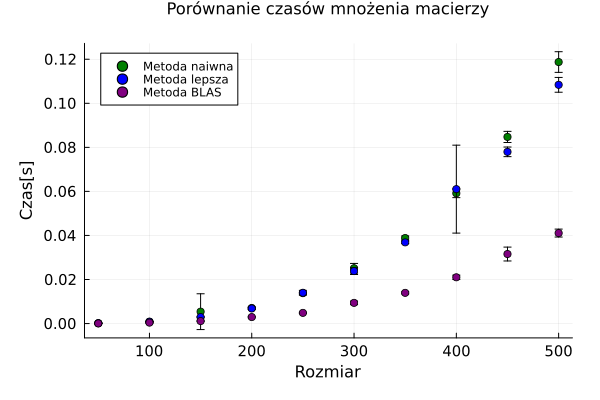

In [25]:
scatter(
    res.Size,  
    margin=5mm,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Rozmiar",
    ylabel = "Czas[s]",
    [res.naive_mean,res.better_mean,res.blas_mean], 
    title = "Porównanie czasów mnożenia macierzy",
    legend_position = :topleft, 
    label = ["Metoda naiwna" "Metoda lepsza" "Metoda BLAS"], 
    color = [:green :blue :purple],
    yerr = [res.naive_std res.better_std res.blas_std]
)

### zad2

```C
#include <stdio.h>
#include <stdlib.h>
#include <gsl/gsl_blas.h>
#include <time.h>

void naive_multiplication(double** A, double** B, double** C, int size){
    for (int i = 0; i < size;i++){
        for (int j = 0; j < size; j++){
            for (int k = 0; k < size; k ++){
                C[i][j] += A[i][k]*B[k][j];
            }
        }     
    }
}
void better_multiplication(double** A, double** B, double** C, int size){
    for (int i = 0; i < size; i++){
        for (int k = 0; k < size; k ++){
            for (int j = 0; j < size; j++){
                C[i][j] += A[i][k]*B[k][j];
            }
        }
    }    
}

void blas_multiplication(double* a, double* b, double* c, int rows){
    gsl_matrix_view D = gsl_matrix_view_array(a, rows, rows);
    gsl_matrix_view E = gsl_matrix_view_array(b, rows, rows);
    gsl_matrix_view F = gsl_matrix_view_array(c, rows, rows);
    gsl_blas_dgemm (CblasNoTrans, CblasNoTrans,
                  1.0, &D.matrix, &E.matrix,
                  0.0, &F.matrix);
}

int main(int argc, char** argv) {
    double **A, **B, **C;
    double *a, *b, *c;
    double time1, time2, time3;
    FILE *raport = fopen("results1.csv","w");
    fprintf(raport,"%s,%s,%s,%s\n","Size","Naive","Better","Blas");

    clock_t start, end;

    for (int i = 50; i <= 500; i += 50){
        A = calloc(i,sizeof(double *));
        B = calloc(i,sizeof(double *));
        C = calloc(i,sizeof(double *));
        a = calloc(i*i, sizeof(double));
        b = calloc(i*i, sizeof(double));
        c = calloc(i*i, sizeof(double));
        for (int j = 0; j < i; j++){
            A[j] = calloc(i,sizeof(double));
            B[j] = calloc(i,sizeof(double));
            C[j] = calloc(i,sizeof(double));
        }
        for (int j = 0; j < 10; j++){
            for (int k = 0; k < i; k ++){
                for (int a = 0; a < i; a ++){
                    A[k][a] = rand()%10;
                    B[k][a] = rand()%10;
                }
            }

            start = clock();
            naive_multiplication(A, B, C, i);
            end = clock();
            time1 = ((double)(end - start)) / CLOCKS_PER_SEC;

            start = clock();
            better_multiplication(A, B, C, i);
            end = clock();
            time2 = ((double)(end - start)) / CLOCKS_PER_SEC;

            for (int k = 0; k < i*i; k++){
                a[k] = A[k/i][k%i];
                b[k] = B[k/i][k%i];
            }

            start = clock();
            blas_multiplication(a, b, c, i);
            end = clock();
            time3 = ((double)(end - start)) / CLOCKS_PER_SEC;

            fprintf(raport,"%d,%f,%f,%f\n",i,time1,time2,time3);
        }
        for (int j = 0; j < i; j++){
            free(A[j]);
            free(B[j]);
            free(C[j]);
        }
        free(A);
        free(B);
        free(C);
        free(a);
        free(b);
        free(c);
    }

    fclose(raport);
    return 0;
}

```
uruchomienie:   
gcc -o lab5 lab5.c -O0 -lgsl -lgslcblas  
./lab5  

In [17]:
results_c = CSV.read("results1.csv", DataFrame)

Row,Size,Naive,Better,Blas
,Int64,Float64,Float64,Float64
1,50,0.001038,0.001138,0.000159
2,50,0.001074,0.001126,0.000117
3,50,0.001182,0.001085,0.000101
4,50,0.000876,0.000879,0.000101
5,50,0.001048,0.001127,0.000117
6,50,0.001146,0.00122,0.000125
7,50,0.001227,0.001258,0.000104
8,50,0.001052,0.000971,8.3e-5
9,50,0.00096,0.001243,0.000119


In [18]:
res_c = combine(groupby(results_c, :Size),
    :Naive => mean => :naive_mean,:Naive => std => :naive_std,
    :Better => mean => :better_mean, :Better => std => :better_std,
    :Blas => mean => :blas_mean, :Blas => std => :blas_std)

Row,Size,naive_mean,naive_std,better_mean,better_std,blas_mean,blas_std
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,50,0.0010697,0.000102809,0.0011171,0.000118331,0.0001107,2.25292e-5
2,100,0.0078721,0.00063267,0.0073177,0.000212436,0.0006675,4.21301e-5
3,150,0.037423,0.00937214,0.0407225,0.00877188,0.0035273,0.000931988
4,200,0.084929,0.0178683,0.0812733,0.0188899,0.0068918,0.0022649
5,250,0.154295,0.0301943,0.1537,0.0273685,0.0132083,0.00368298
6,300,0.186653,0.0973309,0.189913,0.0792389,0.0141125,0.00763412
7,350,0.281054,0.072315,0.2377,0.062941,0.0214001,0.0107471
8,400,0.392685,0.0655376,0.387573,0.0949999,0.0334307,0.0190187
9,450,0.630396,0.178636,0.612904,0.146198,0.050809,0.0271691


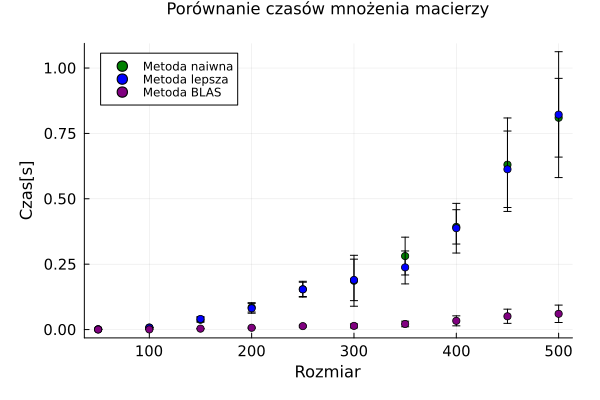

In [19]:
scatter(
    res_c.Size,  
    margin=5mm,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Rozmiar",
    ylabel = "Czas[s]",
    [res_c.naive_mean,res_c.better_mean,res_c.blas_mean], 
    title = "Porównanie czasów mnożenia macierzy",
    legend_position = :topleft, 
    label = ["Metoda naiwna" "Metoda lepsza" "Metoda BLAS"], 
    color = [:green :blue :purple],
    yerr = [res_c.naive_std res_c.better_std res_c.blas_std])

### Zad3

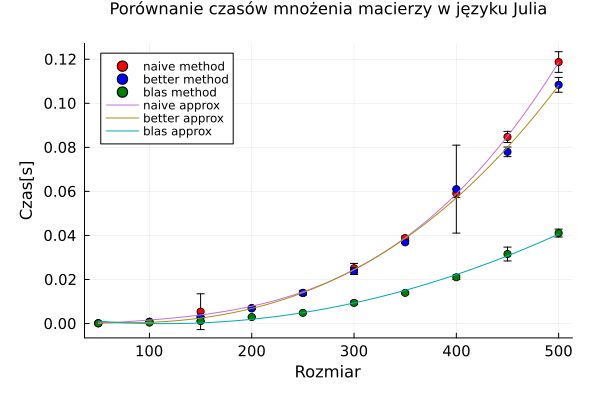

In [20]:
using Polynomials, Plots.PlotMeasures

fit1 = fit(res.Size, res.naive_mean, 3)
fit2 = fit(res.Size, res.better_mean, 3)
fit3 = fit(res.Size, res.blas_mean, 2)
xs = 50:50:500

scatter(
    res.Size,  
    margin = 5mm,
    xtickfontsize = 10, 
    ytickfontsize = 10, 
    titlefontsize = 11,
    xlabel = "Rozmiar",
    ylabel = "Czas[s]",
    [res.naive_mean, res.better_mean, res.blas_mean], 
    title = "Porównanie czasów mnożenia macierzy w języku Julia",
    legend_position = :topleft, 
    label = ["naive method" "better method" "blas method"], 
    color = [:red :blue :green],
    yerr = [res.naive_std res.better_std res.blas_std]
)
plot!(fit1,extrema(xs)...,label="naive approx")
plot!(fit2,extrema(xs)...,label="better approx")
plot!(fit3,extrema(xs)...,label="blas approx")

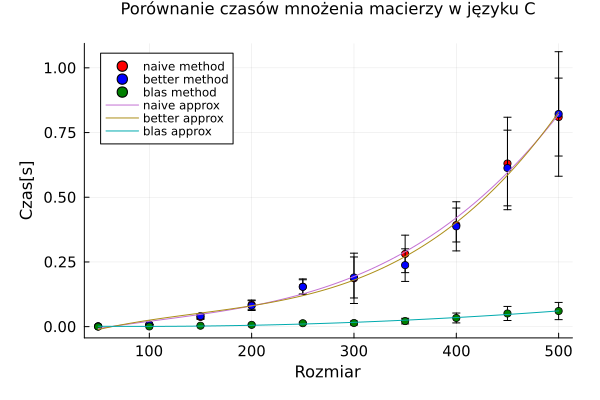

In [21]:
fit4 = fit(res_c.Size, res_c.naive_mean, 3)
fit5 = fit(res_c.Size, res_c.better_mean, 3)
fit6 = fit(res_c.Size, res_c.blas_mean, 2)
xs = 50:50:500

scatter(
    res_c.Size,  
    margin = 5mm,
    xtickfontsize = 10, 
    ytickfontsize = 10, 
    titlefontsize = 11,
    xlabel = "Rozmiar",
    ylabel = "Czas[s]",
    [res_c.naive_mean, res_c.better_mean, res_c.blas_mean], 
    title = "Porównanie czasów mnożenia macierzy w języku C",
    legend_position = :topleft, 
    label = ["naive method" "better method" "blas method"], 
    color = [:red :blue :green],
    yerr = [res_c.naive_std res_c.better_std res_c.blas_std]
)
plot!(fit4,extrema(xs)...,label="naive approx")
plot!(fit5,extrema(xs)...,label="better approx")
plot!(fit6,extrema(xs)...,label="blas approx")

### Zad4

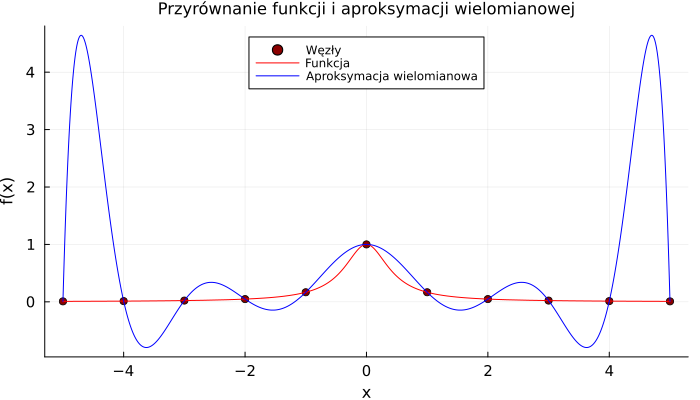

In [22]:
f(x) = 1 / (1 + 5 * x^2)

xs = -5:1:5
ys = [f(x) for x in xs]
poly_approx = fit(xs,ys,10)
xsf = -5:0.01:5
ysf = [poly_approx(x) for x in xsf]


scatter(
    xs,
    ys,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    label="Węzły",
    legend_position=:top,
    size=(700,400),
    color = :darkred,
    title = "Przyrównanie funkcji i aproksymacji wielomianowej",
    xlabel = "x",
    ylabel = "f(x)"
)
plot!(f, extrema(xs)..., label="Funkcja", color = :red)
plot!(xsf, ysf, label="Aproksymacja wielomianowa", color = :blue)

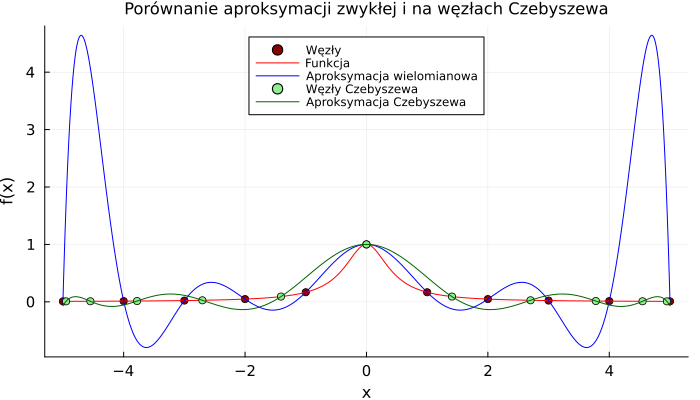

In [23]:
# Dla aproksymacji wielomianowej Chebysheva
chebyshev = ChebyshevT([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]) # Wielomian Czebyszewa - 11 węzłow
nodes = Polynomials.roots(chebyshev)
nodes = 5 * nodes # Przeskalowanie węzłów
ys2 = [f(x) for x in nodes]
poly_approx_2 = fit(nodes, ys2, 10) # aproksymacja stopnia 10
ysf2 = [poly_approx_2(x) for x in xsf]

scatter!(
    nodes, 
    ys2, 
    label = "Węzły Czebyszewa",
    color = :lightgreen, 
    title="Porównanie aproksymacji zwykłej i na węzłach Czebyszewa",
)
ysf2 = [poly_approx_2(x) for x in xsf]
plot!(xsf, ysf2, label = "Aproksymacja Czebyszewa", color = :darkgreen)

Aproksymacja Czebyszewa minimalizuje maksymalną wartość bezwzględną błędu aproksymacji na danym przedziale. Idea aproksymacji Czebyszewa opiera się na wielomianach Czebyszewa, które są wielomianami ortogonalnymi na określonym przedziale. Wielomiany Czebyszewa są zdefiniowane na przedziale [-1, 1] i mają własność, że dla danego stopnia n najwyższa wartość bezwzględna na tym przedziale jest równa 1. Dzięki temu, jeśli funkcję można przybliżyć na danym przedziale za pomocą wielomianu stopnia n, to wielomiany Czebyszewa mogą być używane do minimalizacji maksymalnego błędu aproksymacji.

### Zad5

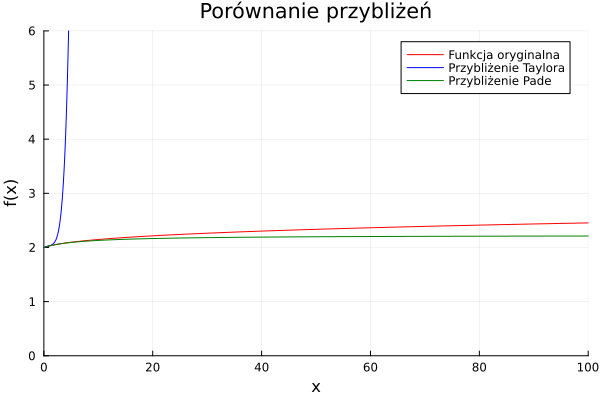

In [24]:
using TaylorSeries

function f(x)
    (7 + ((1 + x)^(4/3))^(1/3))^(1/3)
end

t = Taylor1(Float64, 5) # wielomian 1 rzędu wokół punktu x = 0
f_taylor = f(t)
f_taylor_approx = Polynomial(f_taylor.coeffs)

f_pade = Polynomials.PolyCompat.PadeApproximation.Pade(f_taylor_approx, 2, 2)

xsf = 0:0.1:100
y1 = [f(x) for x in xsf]
y2 = [f_taylor_approx(x) for x in xsf]
y3 = [f_pade(x) for x in xsf]

plot(
    xsf,  
    [y1,y2,y3], 
    xlabel = "x",
    ylabel = "f(x)",
    ylims = [0,6],
    xlims = [0,100],
    title = "Porównanie przybliżeń",
    legend_position = :topright, 
    label = ["Funkcja oryginalna" "Przybliżenie Taylora" "Przybliżenie Pade"], 
    color = [:red :blue :green],
)

Podstawową ideą aproksymacji Padé jest znalezienie najlepszego możliwego ułamka wymiernego, który najlepiej pasuje do danej funkcji na określonym przedziale. Ułamek ten jest zazwyczaj określany jako [M/N], gdzie M jest stopniem wielomianu w liczniku, a N jest stopniem wielomianu w mianowniku.